In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import random
import re
from src.functions import *
import random
import datetime

import absl.logging #prevent checkpoint warnings while training
absl.logging.set_verbosity(absl.logging.ERROR)

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)
from keras import backend as K
from tensorflow.python.client import device_lib

reset_seed()

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print("\n\n devices: ",get_available_devices()) 


%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


2022-06-10 09:38:56.126192: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1




 devices:  ['/device:CPU:0', '/device:GPU:0']


2022-06-10 09:38:57.455039: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-10 09:38:57.457088: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-10 09:38:57.495744: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-06-10 09:38:57.495781: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-10 09:38:57.497690: I tensorflow/stream_executor/platform

# Read data

### Load preprocessed dataset

In [2]:
from src.motion_refiner_4D import Motion_refiner

traj_n = 40
mr = Motion_refiner(load_models=True ,traj_n = traj_n, locality_factor=False)
feature_indices, obj_sim_indices, obj_poses_indices, traj_indices = mr.get_indices()
embedding_indices = np.concatenate([feature_indices,obj_sim_indices, obj_poses_indices])


dataset_name = "4D_80000"

X,Y, data = mr.load_dataset(dataset_name, filter_data = True, base_path="/home/tum/data/data/")
X_train, X_test, X_valid, y_train, y_test, y_valid, indices_train, indices_test, indices_val = mr.split_dataset(X, Y, test_size=0.2, val_size=0.1)


loading BERT model... 

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


done
loading CLIP model... done
loading data... done
raw X: (70000, 952) 	Y: (70000, 160)
filtered X: (69299, 952) 	Y: (69299, 160)
Train X: (48509, 952) 	Y: (48509, 160)
Test  X: (13860, 952) 	Y: (13860, 160)
Val   X: (6930, 952) 	Y: (6930, 160)


In [ ]:
#dataset sample
# %matplotlib qt
from src.functions import *
idx = random.choices(range(len(data)),k=3)
data_sample = list(np.array(data)[idx])
show_data4D(data_sample,image_loader=mr.image_loader)
print(idx)

In [12]:
2077, 1976

In [4]:

#object matching accuracy
mr.evaluate_obj_matching(data)

acc:  0.9924140122329017


0.9924140122329017

# Model

In [5]:

from src.TF4D_ import *
# model_path = "/home/mirmi/Arthur/trajnlp_ws/src/NL_trajectory_reshaper/models/experimet_20220604-173050/"
# model_name =  "TF&num_layers_enc:2&num_layers_dec:4&d_model:256&dff:512&num_heads:8&dropout_rate:0.1&wp_d:4&bs:16&dense_n:512&num_dense:3&concat_emb:True&features_n:792&optimizer:adam&norm_layer:True&activation:linear.h5"

# model_path = "/home/mirmi/Arthur/data/models/TF4D_enc_dec_d/"
# model_name =  "TF&num_layers_enc:1&num_layers_dec:5&d_model:400&dff:512&num_heads:8&dropout_rate:0.1&wp_d:4&bs:16&dense_n:512&num_dense:3&concat_emb:True&features_n:792&optimizer:adam&norm_layer:True&activation:tanh.h5"

model_path = "/home/tum/data/models/TF4D_enc_dec_d/"
model_name =  "TF&num_layers_enc:1&num_layers_dec:5&d_model:400&dff:512&num_heads:8&dropout_rate:0.1&wp_d:4&bs:16&dense_n:512&num_dense:3&concat_emb:True&features_n:792&optimizer:adam&norm_layer:True&activation:tanh.h5"
model_file = model_path+model_name
model = load_model(model_file, delimiter ="&")

# from src.TF4D_mult_features import *
# model_path = "/home/tum/data/models/TF4D_embVec_enc_dec/"
# model_name =  "TF-num_layers_enc:1-num_layers_dec:5-d_model:256-dff:512-num_heads:8-dropout_rate:0.1-wp_d:4-num_emb_vec:8-bs:16-dense_n:512-num_dense:3-concat_emb:True-features_n:792-optimizer:adam-norm_layer:True-activation:linear.h5"
# model_file = model_path+model_name
# model = load_model(model_file, delimiter ="-")


{'num_layers_enc': 1, 'num_layers_dec': 5, 'd_model': 400, 'dff': 512, 'num_heads': 8, 'dropout_rate': 0.1, 'wp_d': 4, 'bs': 16, 'dense_n': 512, 'num_dense': 3, 'concat_emb': True, 'features_n': 792, 'optimizer': 'adam', 'norm_layer': True, 'activation': 'tanh'}


2022-06-10 09:40:38.941645: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-10 09:40:38.942085: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-06-10 09:40:38.942134: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-10 09:40:38.942164: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-10 09:40:38.942183: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-06-10 09:40:38.942199: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.

loading weights:  /home/tum/data/models/TF4D_enc_dec_d/TF&num_layers_enc:1&num_layers_dec:5&d_model:400&dff:512&num_heads:8&dropout_rate:0.1&wp_d:4&bs:16&dense_n:512&num_dense:3&concat_emb:True&features_n:792&optimizer:adam&norm_layer:True&activation:tanh.h5


In [6]:
def prepare_x(x):
  objs = pad_array(list_to_wp_seq(x[:,obj_poses_indices],d=3),4,axis=-1) # no speed
  trajs = list_to_wp_seq(x[:,traj_indices],d=4)
  return np.concatenate([objs,trajs],axis = 1)

test_dataset = tf.data.Dataset.from_tensor_slices((prepare_x(X_test),
                                                  list_to_wp_seq(y_test,d=4),
                                                  X_test[:,embedding_indices])).batch(X_test.shape[0])

x_test_new, y_test_new = prepare_x(X_test), list_to_wp_seq(y_test,d=4)
emb_test_new = X_test[:,embedding_indices]

# x_test_new, y_test_new, emb_test_new= increase_dataset(X_test ,y_test,embedding_indices,10)


In [10]:
result_eval = model.evaluate((x_test_new, y_test_new[:,:-1,:], emb_test_new), y_test_new[:,1:,:])[0]

g = generator(test_dataset,stop=True,augment=False)
x_t, y_t = next(g)
pred = generate(model ,x_t, traj_n=traj_n, start_index=6).numpy()
print(pred.shape)
result_gen = np.average((y_t - pred[:,1:,:])**2)

print("Test loss w generation: ",result_gen)

434/434 [==============================] - 48s 110ms/step - loss: 1.2797e-04 - mean_squared_error: 1.2797e-04


  5%|▌         | 2/39 [01:28<27:12, 44.13s/it]

In [7]:
print("naive predictor")
print(np.average((y_t - x_t[0][:,7:,:])**2))

print("MSE naive cartesian:",np.average((y_t[:,:,:3] - x_t[0][:,7:,:3])**2))
print("MSE model cartesian:",np.average((y_t[:,:,:3] - pred[:,1:,:3])**2))
print("MSE naive vel:",np.average((y_t[:,:,3:] - x_t[0][:,7:,3:])**2))
print("MSE model vel:",np.average((y_t[:,:,3:] - pred[:,1:,3:])**2))


naive predictor
0.005762455522215233
MSE naive cartesian: 0.001543657398243346
MSE model cartesian: 0.001320108700302601
MSE naive vel: 0.01841884989413089
MSE model vel: 0.011582194697996328


In [25]:
%matplotlib qt
indices = np.random.choice(range(len(indices_test)), 6)
# pred_t = np.transpose(pred[:,:,:2],[0,2,1])

data_array = np.array(data)[indices_test[indices]]
show_data4D(data_array, pred=pred[indices],image_loader=mr.image_loader, color_traj=False)

IndexError: index 7270 is out of bounds for axis 0 with size 5

In [31]:
plt.close('all')

In [ ]:
model.summary()

In [ ]:
%matplotlib qt
indices = np.array(range(5))

pred = generate(model ,(x_test_new[indices], y_test_new[indices][:,:-1,:], emb_test_new[indices]), traj_n=traj_n, start_index=6).numpy()
print(pred.shape)
# indices = np.random.choice(range(len(indices_test)), 6)

data_array = np.array(data)[indices_test[indices]]
show_data4D(data_array, pred=pred[indices],image_loader=mr.image_loader, color_traj=False)

## Plot Attention Heatmaps

In [7]:

# m.layers[3].att_weights
# print(tf.executing_eagerly())
tf.config.run_functions_eagerly(True)

print(tf.executing_eagerly())

x_train_new, y_train_new = prepare_x(X_train), list_to_wp_seq(y_train,d=4)
emb_train_new = X_train[:,embedding_indices]


print(x_test_new.shape)
samples = x_test_new.shape[0]
pred_train = model.predict((x_test_new[:samples,:,:], y_test_new[:samples,:-1,:], emb_test_new[:samples,:]))


True
(13860, 46, 4)


2022-06-10 09:42:45.242216: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-10 09:42:45.242626: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2593990000 Hz
2022-06-10 09:42:45.261264: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


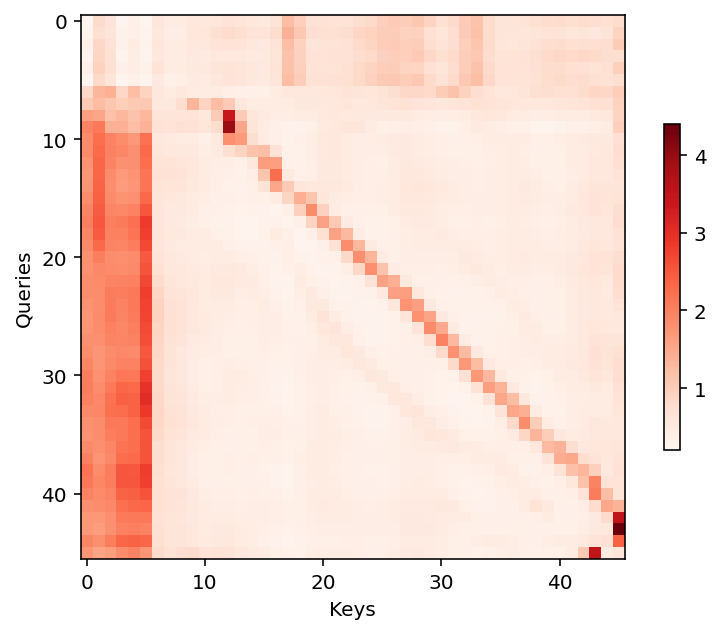

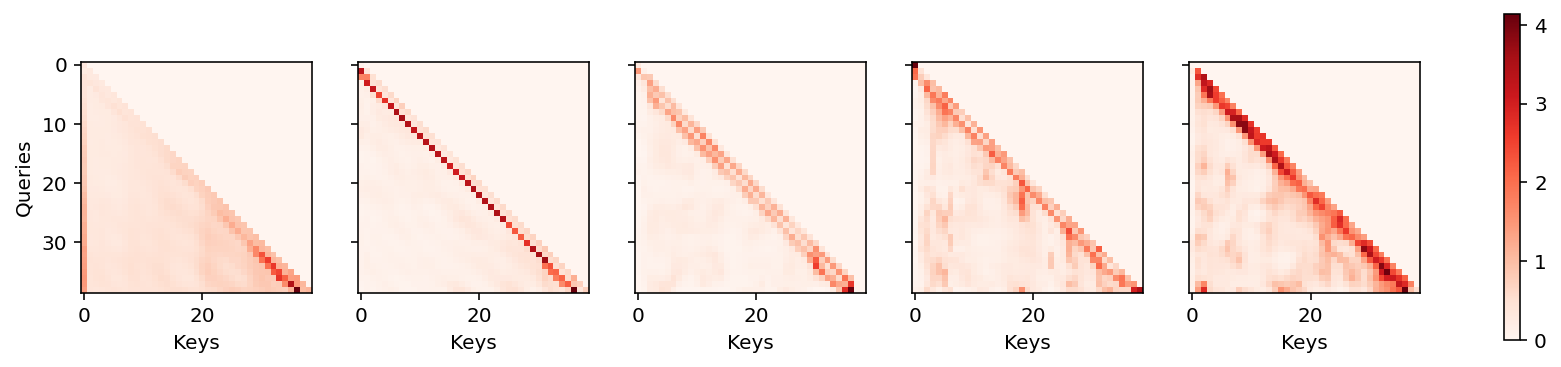

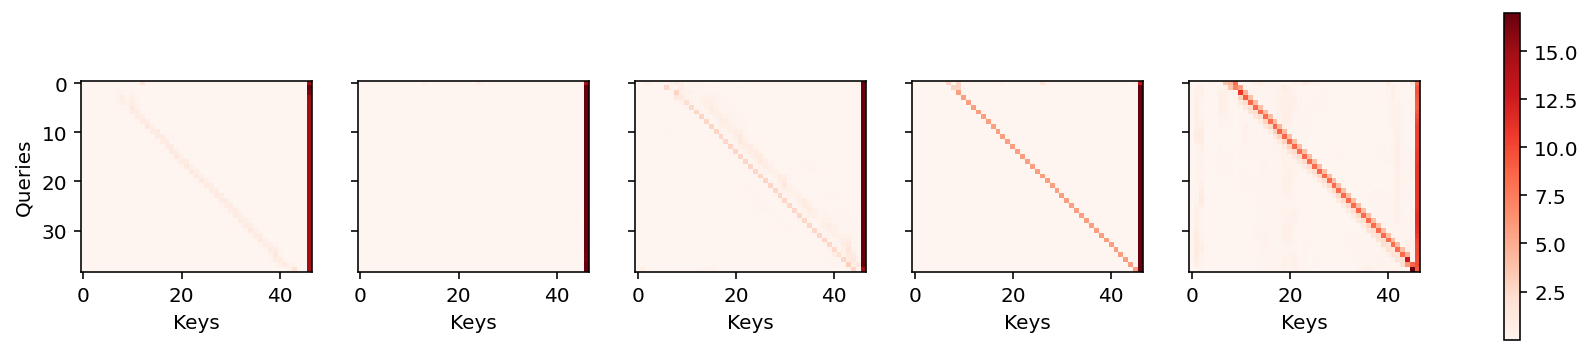

In [8]:
%matplotlib inline
plt.close("all")
def _lower_triangular_mask(shape):
    """Creates a lower-triangular boolean mask over the last 2 dimensions."""
    row_index = np.cumsum(
        np.ones(shape=shape), axis=-2)
    col_index = np.cumsum(
        np.ones(shape=shape), axis=-1)
    return np.greater_equal(row_index, col_index)

def show_heatmaps(matrices,
                  xlabel,
                  ylabel,
                  titles=None,
                  figsize=(15, 6),
                  cmap='Reds',
                  causal = True):
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows,
                             num_cols,
                             figsize=figsize,
                             sharex=True,
                             sharey=True,
                             squeeze=False)
    

    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            att = matrix.numpy()
            if causal:
                att[_lower_triangular_mask(att.shape)==False] = 0
            pcm = ax.imshow(att, cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)



enc_att = model.layers[3]._layers[2][0].multi_head_attention.distribution
enc_att = tf.math.reduce_sum(enc_att,axis=(0,1))
enc_att = tf.reshape(enc_att,(1,1,enc_att.shape[-2],enc_att.shape[-1]))

dec_layers = model.layers[4]._layers[3]
att_list = []
s_att_list = []
enc_att_list = []

for i in range(len(dec_layers)):

    s_att = dec_layers[i].multi_head_attention1.distribution 
    att = dec_layers[i].multi_head_attention2.distribution 

    s_att = tf.math.reduce_sum(s_att,axis=(0,1))
    att = tf.math.reduce_sum(att,axis=(0,1))
    
    s_att = tf.reshape(s_att,(1,1,s_att.shape[-2],s_att.shape[-1]))
    att = tf.reshape(att,(1,1,att.shape[-2],att.shape[-1]))


    s_att_list.append(s_att)
    att_list.append(att)

att_list=tf.concat(att_list,axis=1)
s_att_list=tf.concat(s_att_list,axis=1)
# dec_att = tf.concat([s_att_list,att_list],axis=0)
# print(dec_att.shape)


    # att = tf.reshape(att,(att.shape[0],1,att.shape[-2],att.shape[-1]))
    # print(att.shape)
# with tf.compat.v1.Session().as_default() as sess:  print(att.eval()) 
show_heatmaps(enc_att, causal =False,xlabel='Keys', ylabel='Queries',figsize=(7, 5))

show_heatmaps(s_att_list, causal =True,xlabel='Keys', ylabel='Queries',figsize=(15, 5))
show_heatmaps(att_list, causal =False,xlabel='Keys', ylabel='Queries',figsize=(15, 5))


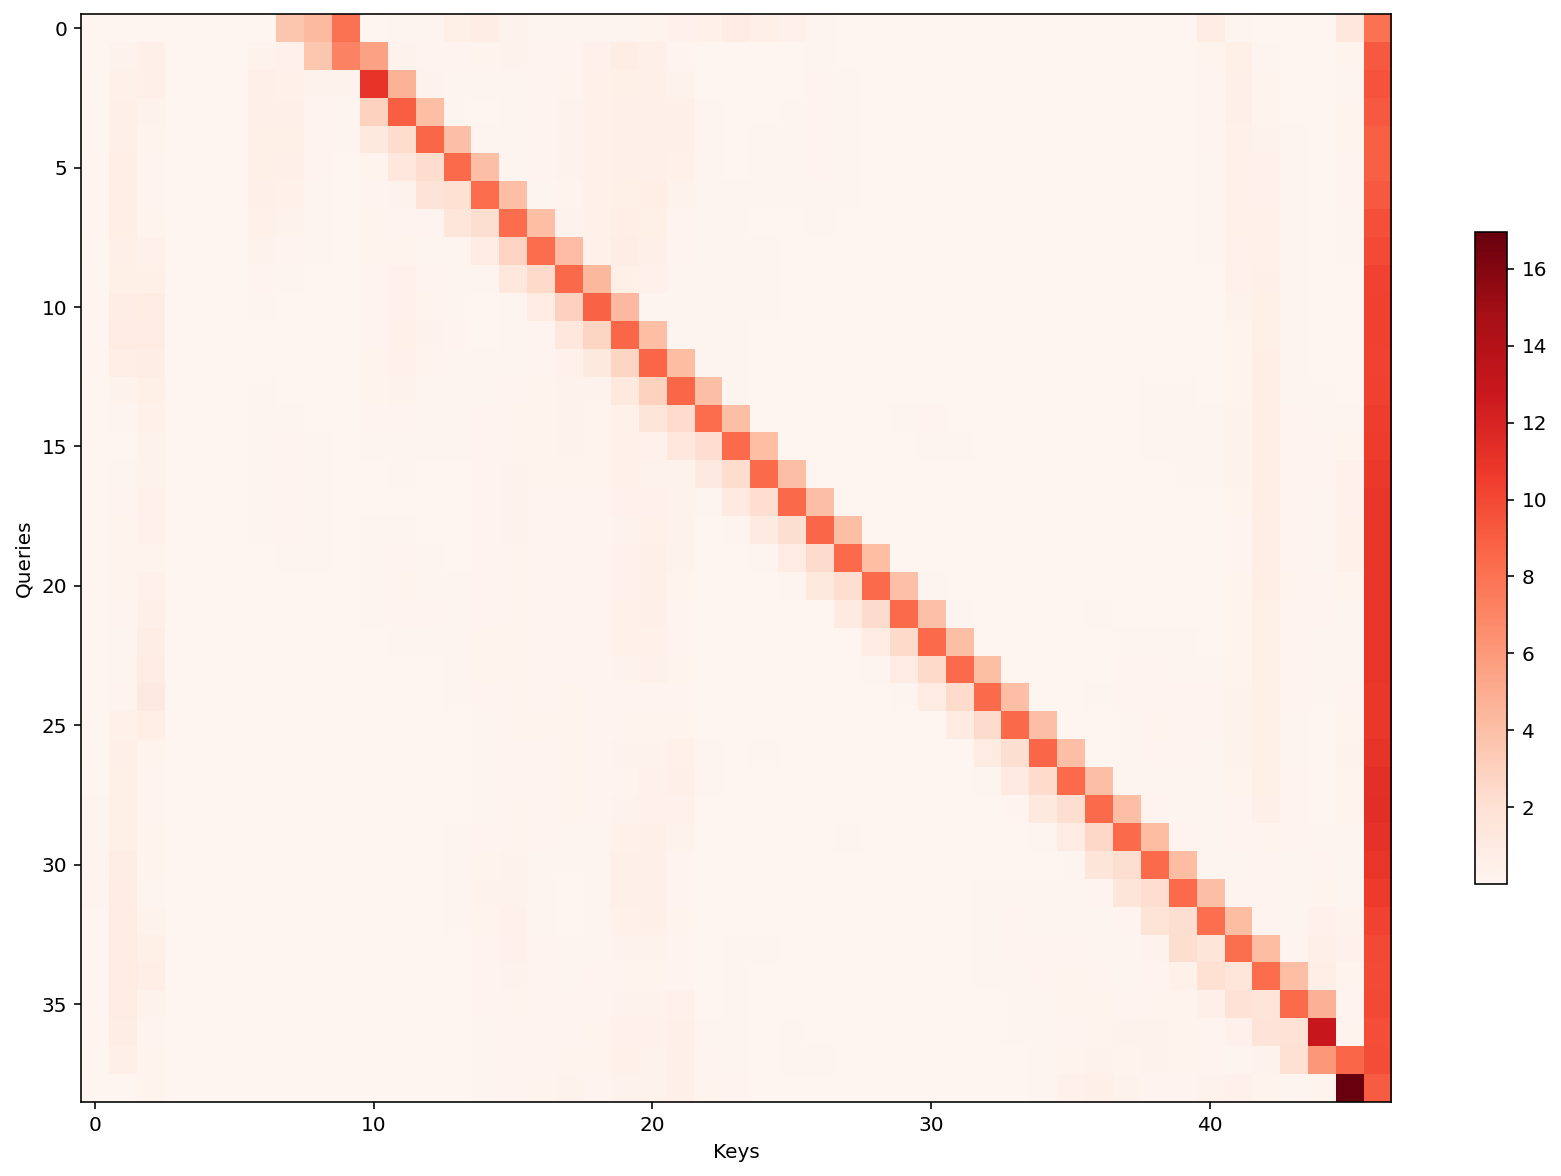

In [9]:
show_heatmaps(att_list[:,4:5,:,:], causal =False,xlabel='Keys', ylabel='Queries',figsize=(15, 10))


## testing

In [ ]:
from src.TF4D_ import *
tf.config.run_functions_eagerly(False)

raw_input_shape = ((None, 46, 4), (None, 39, 4), (None, 792))
# print((x_test_new.shape, y_test_new[:,:-1,:].shape, emb_test_new.shape))

param = {'num_layers_enc': 2, 'num_layers_dec': 4, 'd_model': 256, 'dff': 512, 'num_heads': 8, 'dropout_rate': 0.1, 'wp_d': 4, 'bs': 16, 'dense_n': 512, 'num_dense': 3, 'concat_emb': True, 'features_n': 792, 'optimizer': 'adam', 'norm_layer': True, 'activation': 'linear'}
m = get_model(**param)

m.build((x_test_new, y_test_new[:,:-1,:], emb_test_new))
m.predict((x_test_new, y_test_new[:,:-1,:], emb_test_new))
m.fit((x_test_new, y_test_new[:,:-1,:], emb_test_new),y_test_new[:,1:,:])
# m.layers[3].model().layers[1].output
# m.layers[3].att_weights
# tf.keras.Model(inputs=[new_model.input], outputs=new_model.get_layer("encoder_2").output).summary()


In [ ]:
tf.keras.utils.plot_model(model, expand_nested=True, show_shapes=True)